## Convert paradigm epochs to current format

In [ ]:
import pandas as pd
import numpy as np

file = "/data/Clustering/SleepDeprivation/RatN/Day2/RatN_Day2_2019-10-11_03-58-54_epochs.npy"

data = np.load(file, allow_pickle=True).item()

epochs = pd.DataFrame(data)
a = epochs.T.reset_index()

epochs_new = pd.DataFrame(
    {"start": a[0], "stop": a[1], "label": a["index"].str.lower()}
)
metadata = None

data = {"epochs": epochs_new, "metadata": metadata}

# np.save(file[:-11] + ".paradigm.npy", data)


In [63]:
import numpy as np

a = np.array([2,6,7,3])
b = np.array([3,1,8,4])

corr = np.corrcoef(a,b)
print(corr)

a1 = np.pad(a,pad_width=5,mode = 'constant',constant_values = (0,0))
b1 = np.pad(b,pad_width=5,mode = 'constant',constant_values = (0,0))

corr1 = np.corrcoef(a1,b1)

print(corr1)


[[1.        0.3805212]
 [0.3805212 1.       ]]
[[1.         0.81110267]
 [0.81110267 1.        ]]


In [ ]:
from scipy.linalg import block_diag
import numpy as np
import subjects

sess = subjects.sd.ratSday3[0]

wav = sess.neurons.waveforms

a = np.arange(25).reshape(5,5)
b = np.arange(12).reshape(4,3)

block_diag(*[wav,wav])

<AxesSubplot:>

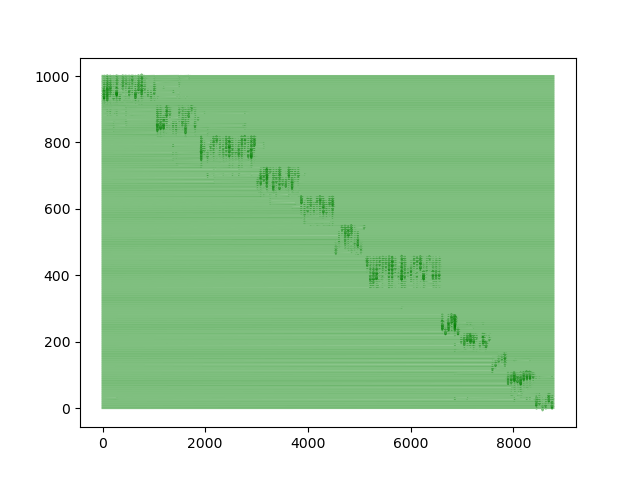

In [67]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from neuropy.plotting import plot_waveforms
import subjects

sess = subjects.sd.ratSday3[0]
shank_ids = sess.neurons.shank_ids
sort_ind = np.argsort(shank_ids)[::-1]
plot_waveforms(sess.neurons,sort_order=sort_ind,color='g')

In [68]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from neuropy.plotting import plot_waveforms
import subjects

sess = subjects.sd.ratSday3[0]
wav = sess.neurons.waveforms

a1,b1 = wav[20],wav[25]
b1 = np.where(b1!=0,b1,np.nan)
# plot_wv = a1
corr = np.corrcoef(a1.astype('float'),b1.astype('float'))
# plt.imshow(corr[173:,:173])
# plt.plot(b1.T+np.linspace(0,500,a1.shape[0]))

/home/bapung/miniconda3/envs/data_analysis/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/bapung/miniconda3/envs/data_analysis/lib/python3.9/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [69]:
waveforms = sess.neurons.waveforms
# waveforms = np.where(waveforms!=0,waveforms,np.nan)
mx = np.ma.masked_equal(waveforms,value=0)
waveforms = np.ma.reshape(mx, (sess.neurons.n_neurons, -1)).astype(float)
similarity = np.ma.corrcoef(waveforms)
np.fill_diagonal(similarity, 0)

In [74]:
bins = np.arange(-1,1,0.001)
hist_sim = np.histogram(similarity,bins=bins)[0]

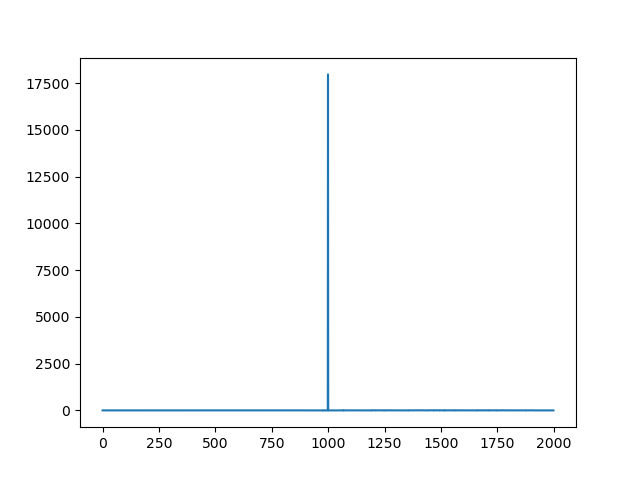

In [75]:
%matplotlib widget
# plt.imshow(similarity[np.ix_(sort_ind,sort_ind)])
plt.plot(hist_sim)

In [ ]:
%matplotlib widget
sim = sess.neurons.get_waveform_similarity()
plt.imshow(sim[np.ix_(sort_ind,sort_ind)])

## Convert artifact to current format

In [ ]:
import pandas as pd
import numpy as np

file = "/data/Clustering/SleepDeprivation/RatS/Day3SD/RatS_Day3SD_2020-11-29_07-53-30.artifact.npy"

data = np.load(file, allow_pickle=True).item()

epochs = pd.DataFrame(
    {"start": data["time"][:, 0], "stop": data["time"][:, 1], "label": ""}
)
metadata = {"channels": data["channel"], "thresh": data["threshold"]}
data = {"epochs": epochs, "metadata": metadata}

# np.save(file, data)


In [ ]:
import subjects
from ModulesPath.core import Position, Track

sess = subjects.Sd.ratSday3[0]

pos = Position(
    time=sess.position.t,
    x=sess.position.x,
    y=sess.position.y,
    sampling_rate=int(sess.position.tracking_sRate),
)

int(pos.sampling_rate)

pos.linearize(period=sess.paradigm.maze1, sample_sec=3)
pos.linearize(period=sess.paradigm.maze2, sample_sec=3)


In [ ]:
import numpy as np
from probeinterface import Probe, ProbeGroup
from probeinterface.plotting import plot_probe_group, plot_probe

n = 24
positions = np.zeros((n, 2))
for i in range(n):
    x = i // 8
    y = i % 8
    positions[i] = x, y
positions *= 20
positions[8:16, 1] -= 10

probe_2d = Probe(ndim=2, si_units="um")
probe_2d.set_contacts(positions=positions, shapes="circle", shape_params={"radius": 5})
probe_2d.create_auto_shape(probe_type="tip")


In [ ]:
from neo.io import RawBinarySignalIO
import quantities as pq

file = (
    "/data/Clustering/SleepDeprivation/RatR/Day2SD/RatR_Day2SD_2021-05-23_09-07-18.eeg"
)
reader = RawBinarySignalIO(filename=file, sampling_rate=1250, nb_channel=128)


In [ ]:
%matplotlib widget
import matplotlib.pyplot as plt
plt.plot(a)

In [ ]:
import numpy as np
from ModulesPath.io import NeuroscopeIO

In [ ]:
info = NeuroscopeIO(
    "/data/Clustering/SleepDeprivation/RatJ/Day1/RatJ_Day1_2019-05-31_03-55-36.xml"
)


In [ ]:
from pathlib import Path

folder = Path("/data/Clustering/SleepDeprivation/RatJ/Day1")
a = folder.glob("*.xml")
for file in folder.iterdir():
    if file.suffix == ".xml":
        print(file.name)


In [ ]:
import numpy as np

file = "/data/Clustering/SleepDeprivation/RatN_Day1_test_neuropy/RatN_Day1_2019-10-09_03-52-32.eeg"
data = np.memmap(file, dtype="int16", mode="r")
data = np.memmap.reshape(data, (len(data) // 134, 134)).T


In [ ]:
from spikeextractors import BinDatRecordingExtractor

a = BinDatRecordingExtractor(file, sampling_frequency=1250, numchan=134, dtype="int16")
a._epochs

In [ ]:
a.get_traces(channel_ids=[1, 4])


In [ ]:
from neuropy.core import animal

a = animal.Animal()

In [ ]:
import numpy as np
from pathlib import Path

file = Path("/data/Clustering/SleepDeprivation/RatN_Day1_test_neuropy/params.py")

params = {}
with file.open("r") as f:
    for line in f:
        line_values = (
            line.replace("\n", "").replace('r"', '"').replace('"', "").split("=")
        )
        params[line_values[0].strip()] = line_values[1].strip()


params

In [ ]:
import pandas as pd
from pathlib import Path

file = Path("/data/Clustering/SleepDeprivation/RatN_Day1_test_neuropy/cluster_info.tsv")
data = pd.read_csv(file, delimiter="\t")
a = data[data["group"].isin(["mua", "good"])].reset_index(drop=True)

b = np.arange(10)
for i in data.itertuples():
    np.where(b == i.id)


In [ ]:
from pathlib import Path
from neuropy.io import PhyIO
from neuropy.core import Neurons

phy_data = PhyIO(
    Path(
        "/home/bapung/Documents/ClusteringHub/spykcirc/RatR/Day2SD/Allsession/RatR_Day2SD_2021-05-23_09-07-18-1.GUI"
    )
)

neurons = Neurons(
    phy_data.spiketrains, t_stop=53000, t_start=0, sampling_rate=phy_data.sampling_rate
)


In [ ]:
import numpy as np
from neuropy.core import Position


x = np.random.randn(10)
y = np.random.randn(10)
z = np.random.randn(10)
t = np.arange(0,10)

pos = Position(t,x,y,z,sampling_rate=1)



In [ ]:
import numpy as np
from neuropy.core import Mua

mua = Mua(spike_counts=np.array([1,2,3]),bin_size=0.2)

In [ ]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np

file1 = '/data/Clustering/sessions/RatS/Day2NSD/RatS-Day2NSD-2020-11-27_10-22-29_position.npy'
file2 = '/data/Clustering/sessions/RatS/Day2NSD/RatS-Day2NSD-2020-11-27_10-22-29.position.npy'

data1 = np.load(file1,allow_pickle=True).item()
data2 = np.load(file2,allow_pickle=True).item()


plt.plot(data1['x'])
plt.plot(data2['traces'][1])

In [ ]:
import numpy as np

file = '/data/Clustering/sessions/RatN/Day2/2019-10-11_03-58-54/experiment1/recording1/continuous/Rhythm_FPGA-100.0/timestamps.npy'

data = np.load(file)

In [ ]:
import pandas as pd

duration = pd.Timedelta(30120/30000,unit='sec')

In [ ]:
fileName ='/data/Clustering/sessions/RatN/Day2/position/Take 2019-10-11 04.08.48 AM.fbx'

with open(fileName) as f:
    next(f)
    for i, line in enumerate(f):

        m = "".join(line)

        if "KeyCount" in m:
            print(m)
            # print("break at i = " + str(i))
            # line_frame = linecache.getline(fileName, i + 2).strip().split(" ")
            break



In [ ]:
import numpy as np

file = '/data/Clustering/sessions/RatU/RatUDay2NSD/RatU_Day2NSD_2021-07-24_08-16-38.paradigm.npy'

data = np.load(file,allow_pickle=True).item()
data['epochs']


In [ ]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt

file_name = "RatU_Day4SD_2021-07-29_08-23-06.eeg_sample.eeg"
n_channels = 192 # number of recorded channels in the file
sampling_rate = 1250
# reading data from binary file and reshaping to n_channels x time format
data = np.memmap(file_name,dtype='int16',mode='r').reshape(-1,n_channels).T

#let's plot data from first channel
plt.plot(data[0])


In [ ]:
import subjects

sess = subjects.sd.ratUday4[0]
signal = sess.eegfile.get_signal([15],1000,2000)

In [ ]:
%matplotlib widget
import matplotlib.pyplot as plt

plt.plot(signal.traces[0]*0.195)

In [ ]:
import matplotlib.pyplot as plt

tPlot, axes = plt.subplots(
    nrows=2, ncols=1, sharex=True, sharey=False, gridspec_kw={"height_ratios": [2, 1]}
)

tPlot.suptitle("node", fontsize=20)

axes[0].plot(range(10), "ro-")
axes[1].plot(range(10), "bo-")
# axes[2].plot(range(10),'go-')
# axes[3].plot(range(10),'mo-')


In [ ]:
from neuropy.analyses import NeuronEnsembles
import subjects

sess = subjects.nsd.ratUday2[0]

maze_ensembles = NeuronEnsembles(
    sess.neurons.get_neuron_type("pyr"), t_start=20000, t_stop=25000
)


In [ ]:
%matplotlib widget
import numpy as np
from neuropy.plotting import Fig

def example_plot(ax, fontsize=12, hide_labels=False):
    pc = ax.pcolormesh(np.random.randn(30, 30), vmin=-2.5, vmax=2.5)
    if not hide_labels:
        ax.set_xlabel('x-label', fontsize=fontsize)
        ax.set_ylabel('y-label', fontsize=fontsize)
        ax.set_title('Title', fontsize=fontsize)
    return pc

figure = Fig()
fig,gs = figure.draw(grid=(4,4))

ax = figure.add_subplot(gs[:,2:])
ax.plot(np.arange(10),np.arange(10))

subfig = fig.add_subfigure(gs[:,:2])
axsLeft = subfig.subplots(1, 2, sharey=True)
subfig.set_facecolor('0.75')
for ax in axsLeft:
    pc = example_plot(ax)
subfig.suptitle('Left plots', fontsize='x-large')
subfig.colorbar(pc, shrink=0.6, ax=axsLeft, location='bottom')

In [ ]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(6,2,sharey=True,sharex=True,gridspec_kw={'height_ratios':[1,3,1,3,1,3]})

In [ ]:
import subjects
from neuropy.core import Epoch

sess = subjects.sd.ratSday3[0]
sess.neurons.waveforms.shape



In [ ]:
import numpy as np

file = '/data/Clustering/sessions/RatS/Day3SD/spykcirc/RatS_Day3SD_2020-11-29_07-53-30.GUI/similar_templates.npy'

data = np.load(file,allow_pickle=True)

In [ ]:
data.shape

In [ ]:
%matplotlib widget
import matplotlib.pyplot as plt

plt.pcolormesh(data)

In [ ]:
import subjects

sess = subjects.sd.ratSday3[0]

In [ ]:
sig = sess.eegfile.get_signal(0)

In [ ]:
sess.probegroup.to_dataframe()